In [ ]:
# 4aeb460f0c974611ef8db66c9a660e8c

In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os

In [22]:
tickers = ['XLY', 'XLP', 'XLE', 'XLK', 'XLV', 'XLF', 'XLI', 'XLB', 'XLU']
DATA_DIR = "./data"

sector_data = {}

for ticker in tickers:
    file_path = os.path.join(DATA_DIR, f"{ticker}.csv")
    df = pd.read_csv(file_path, parse_dates=["Date"])
    
    # Drop rows with missing values (e.g., dividend days)
    df = df.dropna(subset=["Adj Close"])  
    
    # Set Date as index and keep only Adjusted Close
    df = df.set_index("Date")[["Adj Close"]]
    df.rename(columns={"Adj Close": ticker}, inplace=True)
    
    sector_data[ticker] = df

# Combine into single DataFrame
etf_data = pd.concat(sector_data.values(), axis=1).sort_index()

# Preview
etf_data.head()

,XLY,XLP,XLE,XLK,XLV,XLF,XLI,XLB,XLU
Date,,,,,,,,,
2015-01-02,63.77,36.86,52.74,36.38,58.08,16.53,46.83,39.58,33.96
2015-01-05,62.55,36.60,50.55,35.82,57.78,16.18,45.74,38.57,33.55
2015-01-06,61.93,36.55,49.81,35.39,57.58,15.93,45.18,38.23,33.57
2015-01-07,62.91,37.18,49.92,35.69,58.94,16.10,45.52,38.66,33.90
2015-01-08,63.85,37.74,51.04,36.47,59.95,16.34,46.43,39.58,34.13


In [23]:
# Cell: Load SPY benchmark (same format as sectors)
spy = pd.read_csv("./data/SPY.csv", parse_dates=["Date"])
spy = spy.dropna(subset=["Adj Close"])
spy = spy.set_index("Date")[["Adj Close"]]
spy.rename(columns={"Adj Close": "SPY"}, inplace=True)

# Merge SPY with sector data
etf_data = etf_data.merge(spy, left_index=True, right_index=True, how="inner")

In [39]:
# Cell: Calculate Returns
returns = etf_data.pct_change().dropna()

In [41]:
# Calculate mean return of all sectors each day
mean_returns = returns.mean(axis=1)

# Create labels: 1 if sector return > mean return, else 0
labels = returns.apply(lambda x: (x > mean_returns).astype(int))

In [42]:
# Create rolling average features (e.g., 5-day and 20-day moving averages)
rolling_features = pd.DataFrame()
for ticker in tickers:
    rolling_features[f'{ticker}_5d'] = returns[ticker].rolling(5).mean()
    rolling_features[f'{ticker}_20d'] = returns[ticker].rolling(20).mean()

# Drop NaN values
rolling_features = rolling_features.dropna()
labels = labels.loc[rolling_features.index]

In [43]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(rolling_features, labels, test_size=0.2, random_state=42)

In [44]:
# Initialize and train the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

In [45]:
# Evaluate accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of the model: {accuracy:.2f}')

Accuracy of the model: 0.01


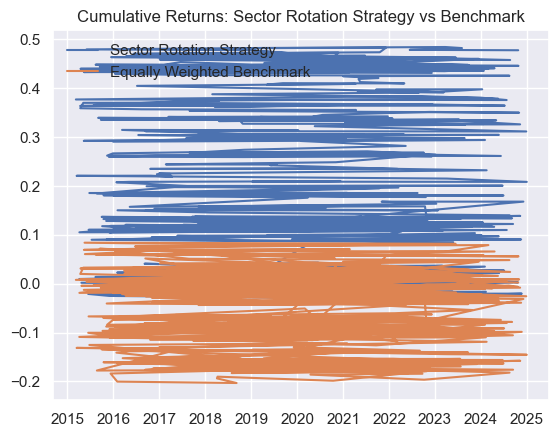

In [46]:
# Simulate sector rotation based on model predictions
investment_returns = pd.DataFrame(index=X_test.index)

# Iterate over each sector (ticker)
for ticker in tickers:
    # Multiply sector returns by the binary predictions (1 for outperform, 0 for underperform)
    investment_returns[ticker] = returns[ticker].loc[X_test.index] * y_pred[:, tickers.index(ticker)]

# Calculate cumulative returns of the sector rotation strategy
rotation_strategy = investment_returns.mean(axis=1).cumsum()

# Benchmark: Cumulative returns of equally weighted portfolio
benchmark = returns.mean(axis=1).loc[X_test.index].cumsum()

# Plot the results
plt.plot(rotation_strategy, label='Sector Rotation Strategy')
plt.plot(benchmark, label='Equally Weighted Benchmark')
plt.legend()
plt.title('Cumulative Returns: Sector Rotation Strategy vs Benchmark')
plt.show()

In [37]:
# Cell: Load & engineer macroeconomic indicators from FRED
from fredapi import Fred

fred = Fred(api_key='4aeb460f0c974611ef8db66c9a660e8c')

macro_series = {
    'CPI': 'CPIAUCSL',
    'Unemployment': 'UNRATE',
    'YieldCurve': 'T10Y2Y',
    'IndustrialProduction': 'INDPRO',
    'FedFunds': 'FEDFUNDS'
}

macro_df = pd.concat(
    [fred.get_series(code).to_frame(name=name) for name, code in macro_series.items()],
    axis=1
)

macro_df.index = pd.to_datetime(macro_df.index)
macro_df = macro_df.resample('M').ffill()

# Align with ETF monthly returns
combined_index = macro_df.index.intersection(monthly_returns.index)

# Create features from macro_df (shifted to prevent lookahead)
macro_features = macro_df.loc[combined_index].shift(1)

# Re-align after shifting (drop the first shifted row)
macro_features = macro_features.loc[combined_index]

# Drop rows with any NaNs after alignment
macro_features = macro_features.dropna()
monthly_returns = monthly_returns.loc[macro_features.index]

# Preview the result
macro_features.head()


,CPI,Unemployment,YieldCurve,IndustrialProduction,FedFunds


In [35]:
macro_frames = []
for name, code in macro_series.items():
    try:
        series = fred.get_series(code).to_frame(name=name)
        print(f"Fetched {name} ({code}) — {series.dropna().shape[0]} rows")
        macro_frames.append(series)
    except Exception as e:
        print(f"Error fetching {name} ({code}): {e}")


Fetched CPI (CPIAUCSL) — 939 rows
Fetched Unemployment (UNRATE) — 927 rows
Fetched YieldCurve (T10Y2Y) — 12217 rows
Fetched IndustrialProduction (INDPRO) — 1275 rows
Fetched FedFunds (FEDFUNDS) — 849 rows


In [ ]:
# Cell: Load & engineer macroeconomic indicators from FRED
from fredapi import Fred

fred = Fred(api_key='4aeb460f0c974611ef8db66c9a660e8c')

macro_series = {
    'CPI': 'CPIAUCSL',
    'Unemployment': 'UNRATE',
    'YieldCurve': 'T10Y2Y',
    'IndustrialProduction': 'INDPRO',
    'FedFunds': 'FEDFUNDS'
}

macro_df = pd.concat(
    [fred.get_series(code).to_frame(name=name) for name, code in macro_series.items()],
    axis=1
)

macro_df.index = pd.to_datetime(macro_df.index)
macro_df = macro_df.resample('M').ffill()

# Align with ETF monthly returns
combined_index = macro_df.index.intersection(monthly_returns.index)

# Create features from macro_df (shifted to prevent lookahead)
macro_features = macro_df.loc[combined_index].shift(1)

# Re-align after shifting (drop the first shifted row)
macro_features = macro_features.loc[combined_index]

# Drop rows with any NaNs after alignment
macro_features = macro_features.dropna()
monthly_returns = monthly_returns.loc[macro_features.index]

# Preview the result
macro_features.head()


,CPI,Unemployment,YieldCurve,IndustrialProduction,FedFunds
